In [1]:
import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# TODO
# - Pathlib 
# - TF functionnal API



In [3]:
# general settings
class CFG:
    data_folder = "./data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [4]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [5]:
def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Memory usage of dataframe is 2.68 MB
Memory usage after optimization is: 0.51 MB
Decreased by 80.9%


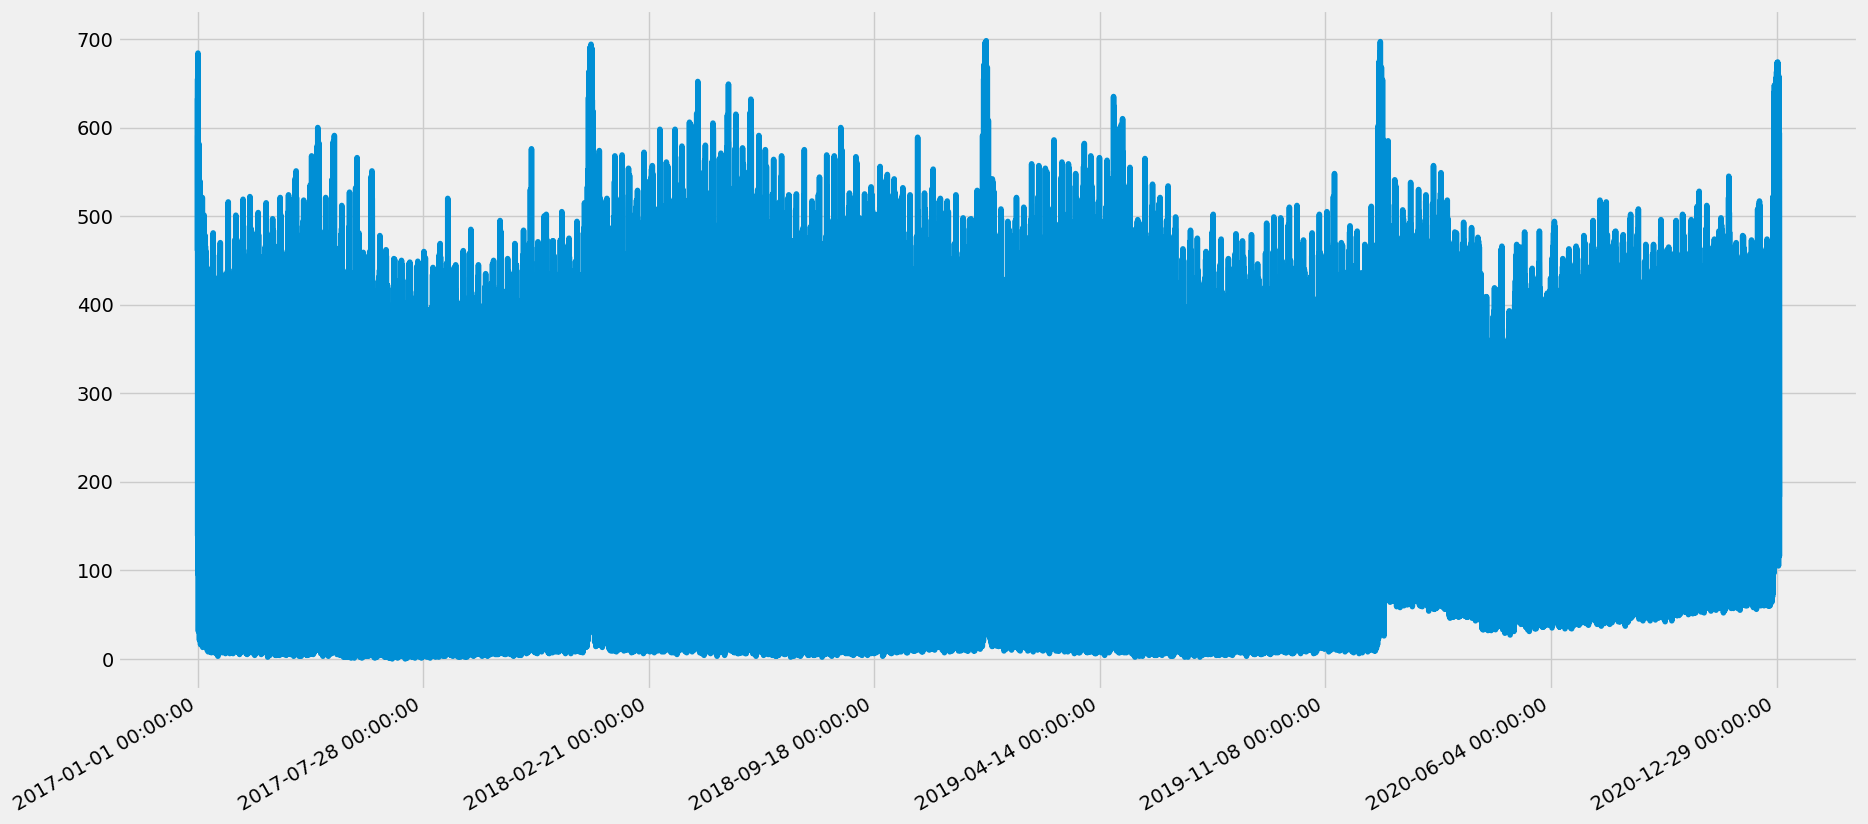

In [7]:
#train_df = pd.read_csv(DATA_FOLDER+"/train.csv", index_col="row_id")
#test_df = pd.read_csv(DATA_FOLDER+"/test.csv", index_col="row_id")
#train_df.info()
#test_df.info()
# load the dataset
cat_feats = ['date','country','store','product', 'num_sold']

df = pd.read_csv(CFG.data_folder+"/train.csv", usecols = cat_feats)
#print(df.head())
for cc in cat_feats[1:]:
    le = LabelEncoder()
    df[cc] = le.fit_transform(df[cc])
df = reduce_mem_usage(df)
#print(df.head())
df['date'] = pd.to_datetime(df['date'])
date = df["date"].copy()
df.set_index("date",  inplace=True)
df.num_sold.plot(xlabel = '')

ytrain = df["num_sold"].copy()

xtrain = df.copy()
xtrain.drop(["num_sold"], axis=1, inplace=True)


In [12]:
xtrain
ytrain

date
2017-01-01 00:00:00    633
2017-01-01 00:00:00    595
2017-01-01 00:00:00    461
2017-01-01 00:00:00    655
2017-01-01 00:00:00    221
                      ... 
2020-12-31 00:00:00    594
2020-12-31 00:00:00    196
2020-12-31 00:00:00    139
2020-12-31 00:00:00    116
2020-12-31 00:00:00    183
Name: num_sold, Length: 70128, dtype: int16

In [8]:

scaler = MinMaxScaler()
#scaler = RobustScaler()
df = scaler.fit_transform(df)
# use 50 historical observations, predict 10 step ahead
look_back = 50
look_ahead = 10


xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(70068, 50) (70068, 10)
(5000, 50, 1) (65068, 50, 1) (5000, 10) (65068, 10)


In [11]:

ydat

array([[0. , 0. , 0. , ..., 0.2, 0.2, 0.2],
       [0. , 0. , 0. , ..., 0.2, 0.2, 0.2],
       [0. , 0. , 0. , ..., 0.2, 0.2, 0.2],
       ...,
       [0.8, 0.8, 0.8, ..., 1. , 1. , 1. ],
       [0.8, 0.8, 0.8, ..., 1. , 1. , 1. ],
       [0.8, 0.8, 0.8, ..., 1. , 1. , 1. ]])

In [14]:

print(df)
df_scaled_robust = RobustScaler().fit_transform(df)
df_scaled_minmax = MinMaxScaler().fit_transform(df)

                     country  store  product  num_sold
date                                                  
2017-01-01 00:00:00        0      0        0       633
2017-01-01 00:00:00        0      0        1       595
2017-01-01 00:00:00        0      0        2       461
2017-01-01 00:00:00        0      0        3       655
2017-01-01 00:00:00        0      1        0       221
...                      ...    ...      ...       ...
2020-12-31 00:00:00        5      0        3       594
2020-12-31 00:00:00        5      1        0       196
2020-12-31 00:00:00        5      1        1       139
2020-12-31 00:00:00        5      1        2       116
2020-12-31 00:00:00        5      1        3       183

[70128 rows x 4 columns]


In [15]:
df_scaled_robust

array([[-0.83333333, -0.5       , -1.        ,  2.68085106],
       [-0.83333333, -0.5       , -0.33333333,  2.4787234 ],
       [-0.83333333, -0.5       ,  0.33333333,  1.76595745],
       ...,
       [ 0.83333333,  0.5       , -0.33333333,  0.05319149],
       [ 0.83333333,  0.5       ,  0.33333333, -0.06914894],
       [ 0.83333333,  0.5       ,  1.        ,  0.28723404]])

In [16]:
df_scaled_minmax

array([[0.        , 0.        , 0.        , 0.90687679],
       [0.        , 0.        , 0.33333333, 0.85243553],
       [0.        , 0.        , 0.66666667, 0.66045845],
       ...,
       [1.        , 1.        , 0.33333333, 0.1991404 ],
       [1.        , 1.        , 0.66666667, 0.16618911],
       [1.        , 1.        , 1.        , 0.26217765]])

In [17]:
print(xtrain.shape, ytrain.shape)
look_back = 50
look_ahead = 50
xtrain = MinMaxScaler().fit_transform(df)
reshape_ratio = xtrain.shape[0]//xtrain.shape[-1]
xdat, ydat = create_dataset(xtrain, look_back = look_back, look_ahead = look_ahead)
# reshape to [batch size, time steps, dimensionality]
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

print(xtrain.shape, ytrain.shape)

(5000, 50, 1) (5000, 50)
(5000, 50, 1) (5000, 50)


In [18]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

def create_model2(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

def create_model_bigger(input):

    model = Sequential([
            #Input(shape = input.shape[-2:]),
            Input(shape = [None,1]),
            Bidirectional(LSTM(400, return_sequences = True)),
            Bidirectional(LSTM(300, return_sequences = True)),
            Bidirectional(LSTM(200, return_sequences = True)),
            Bidirectional(LSTM(100, return_sequences = True)),
            Dense(50, activation = 'selu'),
            Dense(1),
        ])
    
    model.compile(optimizer = "adam", loss = "mae")
    
    return model
model1 = create_model1()
#model2 = create_model2(look_ahead)
#model5 = create_model5(look_ahead)
bigger_model = create_model_bigger(xtrain)

In [15]:
model1.summary()
#model2.summary()
#model5.summary()
bigger_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, None, 800)        1286400   
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 600)        2642400   
 nal)                             

In [20]:
"""
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[early_stop])
"""

"\nearly_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, \n                           patience = 5, mode = 'min', verbose = 1,\n                           restore_best_weights = True)\n\nmodel5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), \n                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[early_stop])\n"

In [47]:
#type(ytrain)
np.concatenate([xtrain, ytrain], axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [38]:
#gkf = GroupKFold(n_splits = 3)
#print((xtrain.shape, ytrain.shape))
#print(xtrain[0])
#print(enumerate(gkf.split(xtrain, ytrain, groups = date.unique())))
#X = xtrain.reshape(xtrain.shape[1:])
#print((xtrain.shape, ytrain.shape))
#for i in enumerate(gkf.split(xtrain[:2], ytrain, groups = date.unique())):
    #print(i)
#for (fold, (id0, id1)) in enumerate(gkf.split(xtrain, ytrain, groups = date.unique())):
    #print((fold, id0, id1))   
    # 
look_back = 50
look_ahead = 10


xdat, ydat = create_dataset(xtrain, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back) 

(0,) (0, 10)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [44]:

type(xtrain)

numpy.ndarray

In [19]:

#gkf = GroupKFold(n_splits = 5)

#print(gkf.get_n_splits(xtrain, ytrain, date))
scheduler = ExponentialDecay(1e-3, 400*((len(xtrain)*0.8)/CFG.BATCH_SIZE), 1e-5)
lr = LearningRateScheduler(scheduler, verbose = 1)
        
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                        patience = 5, mode = 'min', verbose = 1,
                        restore_best_weights = True
                        )
# fit 
bigger_model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs = CFG.nepochs, batch_size = CFG.BATCH_SIZE, callbacks = [early_stop , lr])

"""
for (fold, (id0, id1)) in enumerate(gkf.split(xtrain, ytrain, groups = date.unique())):
    print((fold, id0, id1))

    X_train, X_valid = xtrain[id0], xtrain[id1]
    y_train, y_valid = ytrain[id0], ytrain[id1]
    model = create_model_bigger()        

    scheduler = ExponentialDecay(1e-3, 400*((len(X_train)*0.8)/CFG.BATCH_SIZE), 1e-5)
    lr = LearningRateScheduler(scheduler, verbose = 1)
        
    early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                            patience = 5, mode = 'min', verbose = 1,
                            restore_best_weights = True
                            )

    # fit 
    model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = CFG.nepochs, batch_size = CFG.BATCH_SIZE, callbacks = [early_stop , lr])
    break
"""


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/6
5/5 [==============================] - 281s 62s/step - loss: 0.4479 - val_loss: 0.2622 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009926588973030448.
Epoch 2/6
5/5 [==============================] - 253s 60s/step - loss: 0.2213 - val_loss: 0.1738 - lr: 9.9266e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009853715309873223.
Epoch 3/6


: 

: 

In [ ]:
# predict and calculate RMSE
y_pred1 = model5.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

In [ ]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()